In [387]:
import pandas as pd
import numpy as np
import collections as c
from sklearn.utils import shuffle
from itertools import cycle
from scipy import interp
import csv
from time import time
import datetime
from datetime import timedelta
import math


import seaborn as sns
sns.set(style="whitegrid", palette="deep")
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [18]:
reg_season = pd.read_csv('data/RegularSeasonDetailedResults.csv')
date_cols = ['Dayzero']
seasons = pd.read_csv('data/Seasons.csv', parse_dates=date_cols, infer_datetime_format=True)

#seasons = pd.read_csv('data/Seasons.csv', index_col = 'Season')
teams = pd.read_csv('data/Teams.csv')#, index_col = 'Team_Id')

In [35]:
seasons = seasons[['Season', 'Dayzero']]

In [16]:
reg_season2 = reg_season.copy()

In [21]:
reg_season2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76636 entries, 0 to 76635
Data columns (total 34 columns):
Season    76636 non-null int64
Daynum    76636 non-null int64
Wteam     76636 non-null int64
Wscore    76636 non-null int64
Lteam     76636 non-null int64
Lscore    76636 non-null int64
Wloc      76636 non-null object
Numot     76636 non-null int64
Wfgm      76636 non-null int64
Wfga      76636 non-null int64
Wfgm3     76636 non-null int64
Wfga3     76636 non-null int64
Wftm      76636 non-null int64
Wfta      76636 non-null int64
Wor       76636 non-null int64
Wdr       76636 non-null int64
Wast      76636 non-null int64
Wto       76636 non-null int64
Wstl      76636 non-null int64
Wblk      76636 non-null int64
Wpf       76636 non-null int64
Lfgm      76636 non-null int64
Lfga      76636 non-null int64
Lfgm3     76636 non-null int64
Lfga3     76636 non-null int64
Lftm      76636 non-null int64
Lfta      76636 non-null int64
Lor       76636 non-null int64
Ldr       76636 non-nu

In [23]:
reg_season2 = pd.merge(left=reg_season, right=seasons[['Season', 'Dayzero']], left_on='Season', right_on='Season')

In [29]:
def create_gamedate(row):
    game_date = row['Dayzero'] + datetime.timedelta(days=row['Daynum'])
    return game_date

In [30]:
reg_season2['game_date'] = None
reg_season2['game_date'] = reg_season2.apply(lambda row: create_gamedate(row), axis=1)

In [37]:
reg_season2.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf,Dayzero,game_date
0,2003,10,1104,68,1328,62,N,0,27,58,...,22,10,22,8,18,9,2,20,2002-11-04,2002-11-14
1,2003,10,1272,70,1393,63,N,0,26,62,...,20,20,25,7,12,8,6,16,2002-11-04,2002-11-14
2,2003,11,1266,73,1437,61,N,0,24,58,...,23,31,22,9,12,2,5,23,2002-11-04,2002-11-15
3,2003,11,1296,56,1457,50,N,0,18,38,...,15,17,20,9,19,4,3,23,2002-11-04,2002-11-15
4,2003,11,1400,77,1208,71,N,0,30,61,...,27,21,15,12,10,7,1,14,2002-11-04,2002-11-15


In [32]:
#sort by season and day of game
reg_season2.sort_values(by=['Season', 'Daynum'], inplace=True)

In [229]:
elo_dict = {}
base_elo = 1300  #per Fivethirtyeight.com's NBA base assumption
season_end_elos = []
year = 2017

def create_init_dict():
    for i in range(2003, year+1):
        elo_dict[i] = {}

In [230]:
create_init_dict()

In [231]:
def calc_elo(win_team, lose_team, season):
    winner_rank = get_elo(season, win_team)
    loser_rank = get_elo(season, lose_team)

    """
    This is originally from from:
    http://zurb.com/forrst/posts/An_Elo_Rating_function_in_Python_written_for_foo-hQl
    """
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    #k = 20
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff

    return new_winner_rank, new_loser_rank

In [232]:
def get_elo(season, team):
    try:
        return elo_dict[season][team]
    except:
        try:
            # Get the previous season's ending value discounted (per FiveThirtyEight)
            elo_dict[season][team] = ((elo_dict[season-1][team] * 0.75) + (0.25 * base_elo))
            return elo_dict[season][team]
        except:
            # Get the starter elo.
            elo_dict[season][team] = base_elo
            return elo_dict[season][team]

In [233]:
def build_elo_dict(data):
    for index, row in data.iterrows():
        team_1_elo = get_elo(row['Season'], row['Wteam'])
        team_2_elo = get_elo(row['Season'], row['Lteam'])
        
        if row['Wloc'] == 'H':
            team_1_elo += 100
        elif row['Wloc'] == 'A':
            team_2_elo += 100
        
        team_1_elos = [team_1_elo]
        team_2_elos = [team_2_elo]
        
        season_end_elos.append(team_1_elos + team_2_elos)
        
        new_winner_rank, new_loser_rank = calc_elo(row['Wteam'], row['Lteam'], row['Season'])
        elo_dict[row['Season']][row['Wteam']] = new_winner_rank
        elo_dict[row['Season']][row['Lteam']] = new_loser_rank
        
        
    return season_end_elos

In [357]:
build_elo_dict(reg_season)

[[1300, 1300],
 [1300, 1300],
 [1300, 1300],
 [1300, 1300],
 [1300, 1300],
 [1400, 1300],
 [1400, 1300],
 [1284, 1284],
 [1300, 1300],
 [1416, 1316],
 [1400, 1300],
 [1300, 1300],
 [1300, 1300],
 [1400, 1300],
 [1284, 1284],
 [1284, 1284],
 [1416, 1316],
 [1416, 1316],
 [1300, 1400],
 [1400, 1300],
 [1416, 1316],
 [1400, 1300],
 [1400, 1300],
 [1284, 1284],
 [1400, 1300],
 [1432, 1300],
 [1300, 1268],
 [1400, 1300],
 [1400, 1300],
 [1400, 1300],
 [1416, 1316],
 [1416, 1316],
 [1416, 1316],
 [1300, 1300],
 [1416, 1268],
 [1400, 1300],
 [1400, 1300],
 [1400, 1300],
 [1400, 1300],
 [1300, 1416],
 [1300, 1300],
 [1400, 1300],
 [1300, 1353],
 [1300, 1300],
 [1400, 1300],
 [1400, 1284],
 [1400, 1300],
 [1300, 1400],
 [1300, 1400],
 [1300, 1300],
 [1400, 1300],
 [1300, 1400],
 [1400, 1315],
 [1300, 1400],
 [1400, 1300],
 [1300, 1400],
 [1400, 1300],
 [1400, 1300],
 [1300, 1400],
 [1400, 1300],
 [1300, 1300],
 [1400, 1300],
 [1300, 1400],
 [1416, 1316],
 [1400, 1300],
 [1400, 1300],
 [1400, 13

In [360]:
#convert elo_dict into table in order to correct NaN values
elo_df = pd.DataFrame(elo_dict)

In [361]:
#replace NaNs with the individual teams average elo score 
elo_df = elo_df.T.fillna(elo_df.mean(axis=1)).T

In [362]:
#convert back to dictionary in order to convert to appropriate table format for analysis
elo_dict_final = elo_df.to_dict()

In [391]:
def create_elo_table(dic):
    season = []
    team_id = []
    elo = []
    for k, v in dic.items():
        for k1, v1 in v.items():
            season.append(k)
            team_id.append(k1)
            elo.append(v1)
    elo_table = pd.DataFrame(np.column_stack((season, team_id, elo)))
    elo_table.columns = ['season', 'Team_Id', 'elo']
    return elo_table

In [393]:
elo_table = create_elo_table(elo_dict_final)
elo_table.season = elo_table.season.astype(int)
elo_table.Team_Id = elo_table.Team_Id.astype(int)

In [394]:
elo_table.head()

,season,Team_Id,elo
0,2003,1101,1045.25
1,2003,1102,1270.00
2,2003,1103,1291.00
3,2003,1104,1413.00
4,2003,1105,1046.00


In [395]:
elo_table.to_csv('data/elo_table.csv')

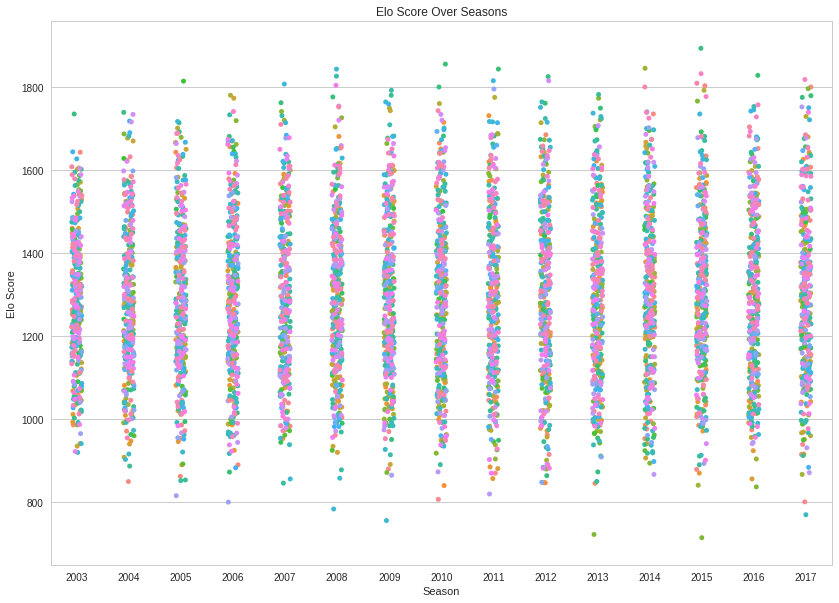

In [396]:
fig = plt.subplots(figsize=(14, 10))
fig = sns.stripplot(x='season', y='elo', hue='Team_Id', data=elo_table, jitter=True)
fig.legend_.remove()
fig.set(xlabel='Season', ylabel='Elo Score', title='Elo Score Over Seasons')
plt.show()